# Exercise: Classify Fashion Items with Support Vector Machines

In this exercise, we'll classify fashion items with support vector machines in scikit-learn. You'll see that image classification is very similar to classification of other data formats, you can directly apply your scikit-learn knowledge from previous lessons! Your tasks are the following:

- Train a support vector machine to classify images of fashion items
- Make predictions and evaluate the model
- Plot the results including a confusion matrix
- Optimize your model using grid search and cross validation
- Evaluate the best model

Acknowledgements: This exercise is loosely based on https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py and https://github.com/zalandoresearch/fashion-mnist. The skorch demo is based on https://www.analyticsvidhya.com/blog/2024/04/train-pytorch-models-scikit-learn-style-with-skorch/. 

In [1]:
# imports
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data Acquisition and Preprocessing

In [2]:
# load the MNIST dataset
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
# load the training and test data
X_train, y_train = load_mnist('../images/fashion', kind='train')
X_test, y_test = load_mnist('../images/fashion', kind='t10k')

In [5]:
# shuffle data
idx = np.arange(len(X_train))
np.random.shuffle(idx)

# we'll only use 10% of the data for speed-up
X_train = X_train[:int(.10*len(idx))]
y_train = y_train[:int(.10*len(idx))]

In [6]:
# store the labels
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

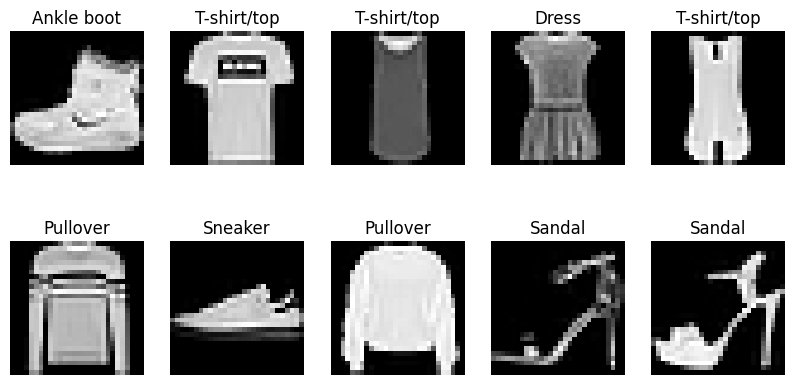

In [7]:
# plot the first 10 images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax[i//5, i%5].imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(classes[y_train[i]])

## 2. Train a Support Vector Machine for Image Classification

In [8]:
# Fit a support vector machine to the data
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [9]:
# Predict the labels of the test set
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy)

Accuracy: 0.80


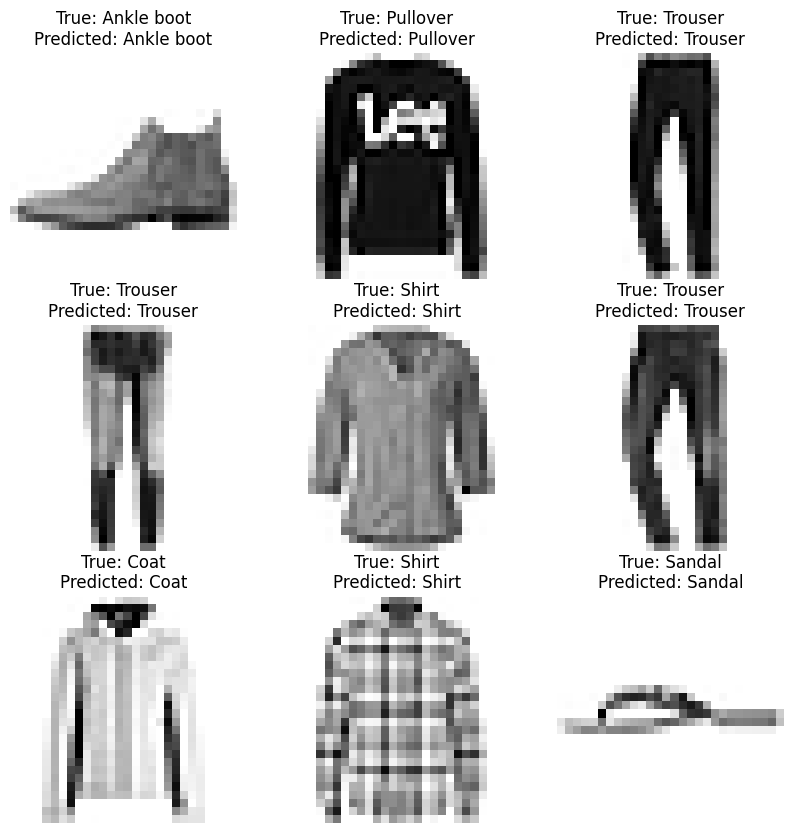

In [10]:
# plot some images and their predicted and true labels
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap='binary')
    ax.set_title('True: %s\nPredicted: %s' % (classes[y_test[i]], classes[y_pred[i]]))
    ax.axis('off')

## 3. Custom Transformer with OpenCV

In [11]:
import cv2

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class OpenCVFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, feature_type='hog'):
        self.feature_type = feature_type

    def fit(self, X, y=None):
        return self  # nothing to fit

    def transform(self, X):
        # X shape is (n_samples, 784) for Fashion MNIST
        # We need to reshape to (n_samples, 28, 28) first
        X_images = X.reshape(-1, 28, 28)
        features = []
        
        for image in X_images:
            # Convert to uint8 for OpenCV
            image = (image * 255).astype(np.uint8)
            
            if self.feature_type == 'hog':
                # Calculate HOG features
                winSize = (28, 28)
                blockSize = (14, 14)
                blockStride = (7, 7)
                cellSize = (7, 7)
                nbins = 9
                hog = cv2.HOGDescriptor(winSize, blockSize, 
                                      blockStride, cellSize, nbins)
                feature = hog.compute(image)
                
            elif self.feature_type == 'edges':
                # Calculate edge features using Canny
                edges = cv2.Canny(image, 50, 150)
                feature = edges.flatten()
            
            features.append(feature.flatten())
            
        return np.array(features)

# Create a pipeline with the custom transformer and SVM
pipeline = Pipeline([
    ('features', OpenCVFeatureExtractor(feature_type='hog')),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', random_state=42))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy_custom_pipeline = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f' % accuracy_custom_pipeline)

Accuracy: 0.78


In [12]:
# print all parameters that can be tuned using grid search
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'features', 'scaler', 'svm', 'features__feature_type', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'svm__C', 'svm__break_ties', 'svm__cache_size', 'svm__class_weight', 'svm__coef0', 'svm__decision_function_shape', 'svm__degree', 'svm__gamma', 'svm__kernel', 'svm__max_iter', 'svm__probability', 'svm__random_state', 'svm__shrinking', 'svm__tol', 'svm__verbose'])

In [13]:
from sklearn.model_selection import GridSearchCV

# Optimize over 2x2x2x4=32 combinations of hyperparameters
param_grid = {
    'features__feature_type': ['hog', 'edges'], # try HOG and edge features 
    'svm__C': [1, 10], # Regularization parameter
    'svm__gamma': [0.0001, 0.001], # Kernel coefficient
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'] } # Kernel type

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=linear;, score=0.799 total time=   1.1s
[CV 2/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=linear;, score=0.783 total time=   1.1s
[CV 3/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=linear;, score=0.790 total time=   1.3s
[CV 4/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=linear;, score=0.810 total time=   1.8s
[CV 5/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=linear;, score=0.787 total time=   1.4s
[CV 1/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=rbf;, score=0.787 total time=   4.9s
[CV 2/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=rbf;, score=0.786 total time=   4.5s
[CV 3/5] END features__feature_type=hog, svm__C=1, svm__gamma=0.0001, svm__kernel=rbf;, sc

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features', OpenCVFeatureExtractor()),
                                       ('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(kernel='linear',
                                            random_state=42))]),
             param_grid={'features__feature_type': ['hog', 'edges'],
                         'svm__C': [1, 10], 'svm__gamma': [0.0001, 0.001],
                         'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             verbose=3)

In [14]:
# retrain the best model on the full training set
final_model = grid_search.best_estimator_.fit(X_train, y_train)

# calculate the final accuracy of the best model
y_pred_best = final_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print('Final accuracy:', accuracy_best)

Final accuracy: 0.8391


---
## Demo: CNN Image Classification with PyTorch

In [15]:
# import torch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define CNN model
class CNNClassifier(nn.Module):

    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 7 * 7, 784)
        self.fc2 = nn.Linear(784, 10)

    def forward(self, x):
        # input shape: (batch_size, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        # output shape: (batch_size, 32, 14, 14)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # output shape: (batch_size, 64, 7, 7)

        x = F.relu(self.conv3(x))
        # output shape: (batch_size, 128, 7, 7)

        x = x.view(-1, 128 * 7 * 7)
        # output shape: (batch_size, 128 * 7 * 7)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # output shape: (batch_size, 10)

        return x

In [16]:
# Hyperparameters
max_epochs = 25
lr = 0.001
batch_size = 32
patience = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

# Wrap the model in Skorch NeuralNetClassifier
cnn_classifier = NeuralNetClassifier(
    module = CNNClassifier,
    max_epochs = max_epochs,
    lr = lr,
    iterator_train__batch_size = batch_size,
    iterator_train__shuffle = True,
    iterator_valid__batch_size = batch_size,
    iterator_valid__shuffle = False,
    criterion = nn.CrossEntropyLoss,
    optimizer = torch.optim.Adam,
    callbacks = [EarlyStopping(patience=patience)],
    device = device
)

In [18]:
# Train the model
print('Using device:', device)
print("Training started...")
X_train = X_train.reshape(-1, 1, 28, 28).astype(np.float32) # Reshape for CNN input
y_train = y_train.astype(np.int64)

cnn_classifier.fit(X_train, y_train)
print("Training completed!")


Using device: cpu
Training started...
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.2966       0.8092        0.5613  13.4025
      2        0.4590       0.8425        0.4621  13.1371
      3        0.3634       0.8425        0.4408  12.8623
      4        0.3016       0.8425        0.4303  13.0556
      5        0.2545       0.8683        0.4005  13.6465
      6        0.2123       0.8517        0.4746  19.5774
      7        0.2071       0.8633        0.4081  19.3686
      8        0.1687       0.8642        0.4930  17.1794
      9        0.1380       0.8425        0.5330  14.0566
Stopping since valid_loss has not improved in the last 5 epochs.
Training completed!


In [19]:
# Evaluate the model on test data
X_test = X_test.reshape(-1, 1, 28, 28).astype(np.float32) # Reshape for CNN input
y_test = y_test.astype(np.int64)
y_pred = cnn_classifier.predict(X_test)
accuracy = cnn_classifier.score(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

Test accuracy: 0.8463
